In [2]:
import numpy as np
from scipy.io import loadmat

# Load .mat files
mat_presence = loadmat('dataset_SDR/dataPresence.mat')
mat_small_presence = loadmat('dataset_SDR/dataPresenceHome.mat')
mat_no_presence = loadmat('dataset_SDR/NoPresence.mat')

# Identify actual variable names (excluding meta fields)
presence_var = [key for key in mat_presence.keys() if not key.startswith('__')][0]
small_presence_var = [key for key in mat_small_presence.keys() if not key.startswith('__')][0]
no_presence_var = [key for key in mat_no_presence.keys() if not key.startswith('__')][0]

# Extract data
X_presence = mat_presence[presence_var]
X_small_presence = mat_small_presence[small_presence_var]
X_no_presence = mat_no_presence[no_presence_var]


# Save as .npy
np.save('dataset_SDR/dataPresence.npy', X_presence)
np.save('dataset_SDR/dataSmallPresence.npy', X_small_presence)
np.save('dataset_SDR/NoPresence.npy', X_no_presence)


print("Conversion complete. Saved as .npy files.")


Conversion complete. Saved as .npy files.


In [ ]:
import matplotlib.pyplot as plt

# Load datasets
dataset_no_presence = np.load('dataset_SDR/NoPresence.npy')
dataset_presence = np.load('dataset_SDR/dataPresence.npy')
dataset_small_presence = np.load('dataset_SDR/dataSmallPresence.npy')

print("Dataset (No Presence) shape:", dataset_no_presence.shape)
print("Dataset (Presence) shape:", dataset_presence.shape)
print("Dataset (Small Presence) shape:", dataset_small_presence.shape)

Dataset (No Presence) shape: (52, 8, 500)
Dataset (Presence) shape: (52, 8, 500)
Dataset (Small Presence) shape: (52, 8, 500)


In [4]:

def compute_periodogram(csi_image):
    """
    Compute the 2D periodogram (power spectrum) of the input CSI image.
    - Apply 2D FFT
    - Shift frequencies to center
    - Remove DC components
    - Normalize to [0,1]
    """
    # Step 1: Apply 2D FFT
    fft_result = np.fft.fft2(csi_image)
    
    # Step 2: Shift zero frequency component to the center
    fft_shifted = np.fft.fftshift(fft_result)
    
    # Step 3: Compute the power spectrum (magnitude squared)
    periodogram = np.abs(fft_shifted) ** 2
    
    # Step 4: Remove DC components (center frequency at [mid_x, mid_y])
    mid_x, mid_y = periodogram.shape[0] // 2, periodogram.shape[1] // 2
    periodogram[mid_x, :] = 0  # Remove DC along x-axis
    periodogram[:, mid_y] = 0  # Remove DC along y-axis
    
    # Step 5: Normalize to [0,1]
    periodogram = (periodogram - periodogram.min()) / (periodogram.max() - periodogram.min())
    
    return periodogram

Random capture index: 110


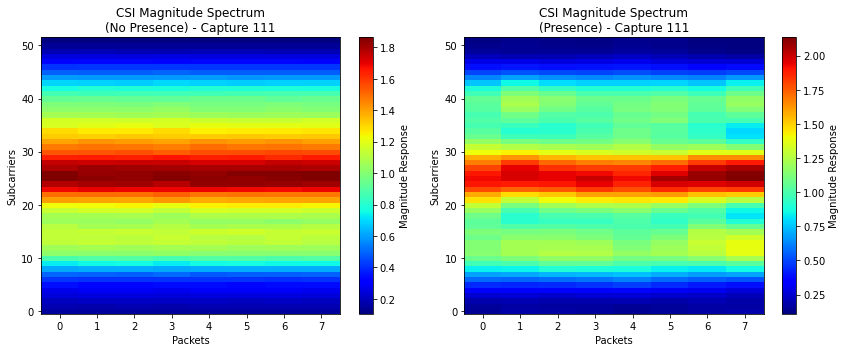

In [5]:
# Select a random capture index for visualization
capture_index = np.random.randint(0, 249)
print("Random capture index:", capture_index)

# Compute the magnitude response (absolute value of complex CSI)
magnitude_no_presence = np.abs(dataset_no_presence[:, :, capture_index])
magnitude_presence = np.abs(dataset_presence[:, :, capture_index])

# Create a horizontal subplot (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Function to plot CSI magnitude spectrum
def plot_magnitude_spectrum(ax, data, title):
    X, Y = np.meshgrid(np.arange(data.shape[1]), np.arange(data.shape[0]))  # Create grid
    c = ax.pcolor(X, Y, data, cmap='jet', shading='auto')
    fig.colorbar(c, ax=ax, label="Magnitude Response")
    ax.set_xlabel("Packets")
    ax.set_ylabel("Subcarriers")
    ax.set_title(title)

# Plot both magnitude spectrums
plot_magnitude_spectrum(axes[0], magnitude_no_presence, f"CSI Magnitude Spectrum\n(No Presence) - Capture {capture_index+1}")
plot_magnitude_spectrum(axes[1], magnitude_presence, f"CSI Magnitude Spectrum\n(Presence) - Capture {capture_index+1}")

# Adjust layout and show
plt.tight_layout()
plt.show()

Selected Capture Index: 35


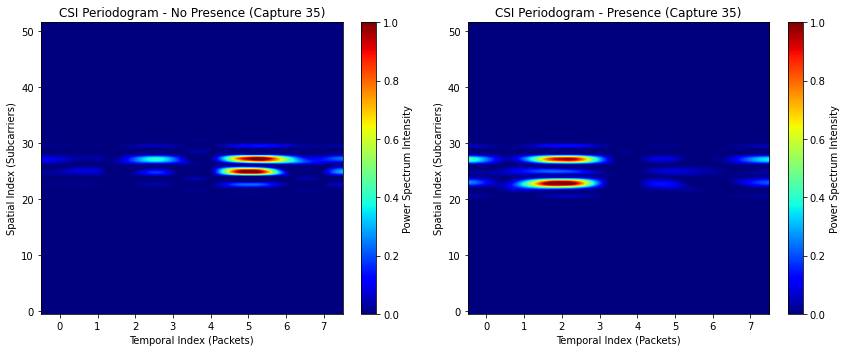

In [6]:
# Select a random capture index for visualization
capture_index = np.random.randint(0, 250)  # Randomly choose a capture
print(f"Selected Capture Index: {capture_index}")

# Compute periodograms for presence and no-presence captures
periodogram_no_presence = compute_periodogram(dataset_no_presence[:, :, capture_index])
periodogram_presence = compute_periodogram(dataset_presence[:, :, capture_index])

# Create a horizontal subplot (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Function to plot the periodogram using imshow()
def plot_periodogram(ax, data, title):
    c = ax.imshow(data, cmap='jet', aspect='auto', origin='lower', interpolation='sinc')
    fig.colorbar(c, ax=ax, label="Power Spectrum Intensity")  # Attach colorbar to correct axis
    ax.set_xlabel("Temporal Index (Packets)")
    ax.set_ylabel("Spatial Index (Subcarriers)")
    ax.set_title(title)

# Visualize periodograms
plot_periodogram(axes[0], periodogram_no_presence, f"CSI Periodogram - No Presence (Capture {capture_index})")
plot_periodogram(axes[1], periodogram_presence, f"CSI Periodogram - Presence (Capture {capture_index})")

plt.tight_layout()  # Adjust layout
plt.show()


Selected Capture Indices: [142   6]


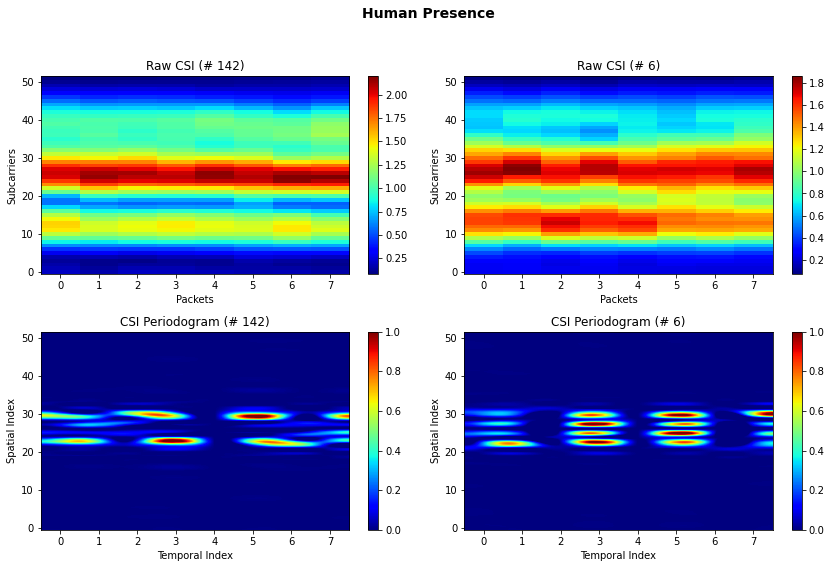

In [7]:
# Randomly select 3 capture indices
np.random.seed(42)  # Set seed for reproducibility
random_captures = np.random.choice(250, 2, replace=False)  # Choose 3 unique indices
print(f"Selected Capture Indices: {random_captures}")

# Create a figure with 2 rows and 3 columns
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Human Presence', fontsize=14, fontweight='bold')

# Plot Raw CSI and Periodogram for each capture
for i, capture_index in enumerate(random_captures):
    # Compute raw CSI magnitude
    raw_csi = np.abs(dataset_presence[:, :, capture_index])

    # Compute periodogram
    periodogram = compute_periodogram(raw_csi)

    # Plot Raw CSI magnitude (Top row)
    ax1 = axes[0, i]
    c1 = ax1.imshow(raw_csi, cmap='jet', aspect='auto', origin='lower', interpolation='none')
    fig.colorbar(c1, ax=ax1)
    ax1.set_title(f"Raw CSI (# {capture_index})")
    ax1.set_xlabel("Packets")
    ax1.set_ylabel("Subcarriers")

    # Plot Periodogram (Bottom row)
    ax2 = axes[1, i]
    # c2 = ax2.imshow(periodogram, cmap='jet', aspect='auto', origin='lower', interpolation='bicubic')
    c2=ax2.imshow(periodogram, cmap='jet', aspect='auto', origin='lower', interpolation='sinc')
    fig.colorbar(c2, ax=ax2)
    ax2.set_title(f"CSI Periodogram (# {capture_index})")
    ax2.set_xlabel("Temporal Index")
    ax2.set_ylabel("Spatial Index")

# Adjust layout and show the plot
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Selected Capture Indices: [142   6]


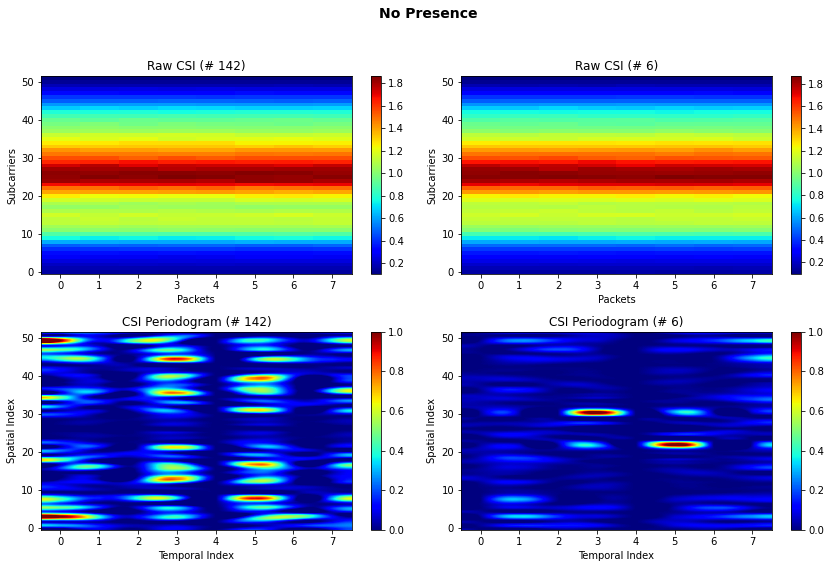

In [8]:
# Randomly select 3 capture indices
np.random.seed(42)  # Set seed for reproducibility
random_captures = np.random.choice(250, 2, replace=False)  # Choose 3 unique indices
print(f"Selected Capture Indices: {random_captures}")

# Create a figure with 2 rows and 3 columns
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('No Presence', fontsize=14, fontweight='bold')

# Plot Raw CSI and Periodogram for each capture
for i, capture_index in enumerate(random_captures):
    # Compute raw CSI magnitude
    raw_csi = np.abs(dataset_no_presence[:, :, capture_index])

    # Compute periodogram
    periodogram = compute_periodogram(raw_csi)

    # Plot Raw CSI magnitude (Top row)
    ax1 = axes[0, i]
    c1 = ax1.imshow(raw_csi, cmap='jet', aspect='auto', origin='lower', interpolation='none')
    fig.colorbar(c1, ax=ax1)
    ax1.set_title(f"Raw CSI (# {capture_index})")
    ax1.set_xlabel("Packets")
    ax1.set_ylabel("Subcarriers")

    # Plot Periodogram (Bottom row)
    ax2 = axes[1, i]
    # c2 = ax2.imshow(periodogram, cmap='jet', aspect='auto', origin='lower', interpolation='bicubic')
    c2=ax2.imshow(periodogram, cmap='jet', aspect='auto', origin='lower', interpolation='sinc')
    fig.colorbar(c2, ax=ax2)
    ax2.set_title(f"CSI Periodogram (# {capture_index})")
    ax2.set_xlabel("Temporal Index")
    ax2.set_ylabel("Spatial Index")

# Adjust layout and show the plot
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Selected Capture Indices: [142   6]


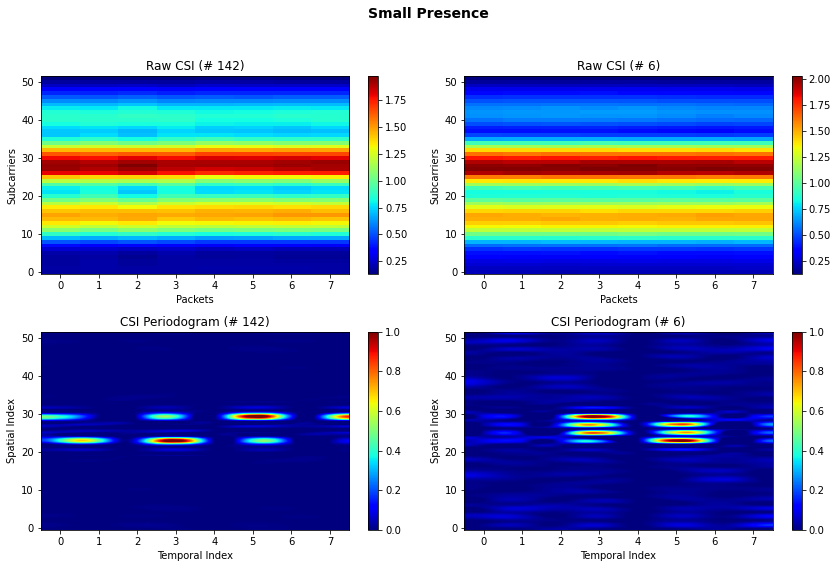

In [12]:
# Randomly select 3 capture indices
np.random.seed(42)  # Set seed for reproducibility
random_captures = np.random.choice(250, 2, replace=False)  # Choose 3 unique indices
print(f"Selected Capture Indices: {random_captures}")

# Create a figure with 2 rows and 3 columns
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Small Presence', fontsize=14, fontweight='bold')

# Plot Raw CSI and Periodogram for each capture
for i, capture_index in enumerate(random_captures):
    # Compute raw CSI magnitude
    raw_csi = np.abs(dataset_small_presence[:, :, capture_index])

    # Compute periodogram
    periodogram = compute_periodogram(raw_csi)

    # Plot Raw CSI magnitude (Top row)
    ax1 = axes[0, i]
    c1 = ax1.imshow(raw_csi, cmap='jet', aspect='auto', origin='lower', interpolation='none')
    fig.colorbar(c1, ax=ax1)
    ax1.set_title(f"Raw CSI (# {capture_index})")
    ax1.set_xlabel("Packets")
    ax1.set_ylabel("Subcarriers")

    # Plot Periodogram (Bottom row)
    ax2 = axes[1, i]
    # c2 = ax2.imshow(periodogram, cmap='jet', aspect='auto', origin='lower', interpolation='bicubic')
    c2=ax2.imshow(periodogram, cmap='jet', aspect='auto', origin='lower', interpolation='sinc')
    fig.colorbar(c2, ax=ax2)
    ax2.set_title(f"CSI Periodogram (# {capture_index})")
    ax2.set_xlabel("Temporal Index")
    ax2.set_ylabel("Spatial Index")


# Adjust layout and show the plot
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [1]:
import torch

print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("CUDA version:", torch.version.cuda)
    print("GPU Name:", torch.cuda.get_device_name(0))
    print("Device Count:", torch.cuda.device_count())
    print("Current Device:", torch.cuda.current_device())
else:
    print("CUDA not available. Using CPU.")


Torch version: 1.10.2+cu102
CUDA available: True
CUDA version: 10.2
GPU Name: NVIDIA GeForce GTX 1650
Device Count: 1
Current Device: 0


In [2]:
import torch
print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")


Torch: 1.10.2+cu102
CUDA available: True
CUDA version: 10.2
GPU: NVIDIA GeForce GTX 1650
